In [3]:
# initial imports
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.integrate import solve_ivp
from sklearn.linear_model import LogisticRegression
import phik as phi_k
#note, make sure to "pip install phik"
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

# How Does Diabetes Relate to Factors of General Health Such as BMI, Cholestorol, Blood Pressure, Diet, Physical Activity and Smoking?


## Kaggle Diabetes Dataset
### https://www.kaggle.com/datasets/akshaydattatraykhare/diabetes-dataset


In [4]:
diabetes1_df = pd.read_csv('Datasets/diabetes.csv')
diabetes1_df.head(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
#This line of code to see more rows of the dataframe to check for 0
pd.set_option('display.max_rows', 100)

#Sorting my BMI column ascending values to weed out the 0's, as a 0 BMI is impossible
diabetes1_df2=diabetes1_df.sort_values(by = ['BMI', 'Age'])

#I'm dropping here all the top rows with 0 for BMI
kagdiabetes=diabetes1_df2.drop(diabetes1_df2.head(11).index)

dropzero=kagdiabetes.sort_values(by = ['SkinThickness', 'Age'])

#Not really possible to have 0 skin thickness, unless you have no skin. Dropping all values for 0 skin thickness
thickzero=dropzero.drop(dropzero.head(218).index)
thickzero

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
254,12,92,62,7,258,27.6,0.926,44,1
519,6,129,90,7,326,19.6,0.582,60,0
382,1,109,60,8,182,25.4,0.947,21,0
434,1,90,68,8,0,24.5,1.138,36,0
55,1,73,50,10,0,23.0,0.248,21,0
...,...,...,...,...,...,...,...,...,...
86,13,106,72,54,0,36.6,0.178,45,0
120,0,162,76,56,100,53.2,0.759,25,1
57,0,100,88,60,110,46.8,0.962,31,0
445,0,180,78,63,14,59.4,2.420,25,1


<AxesSubplot:>

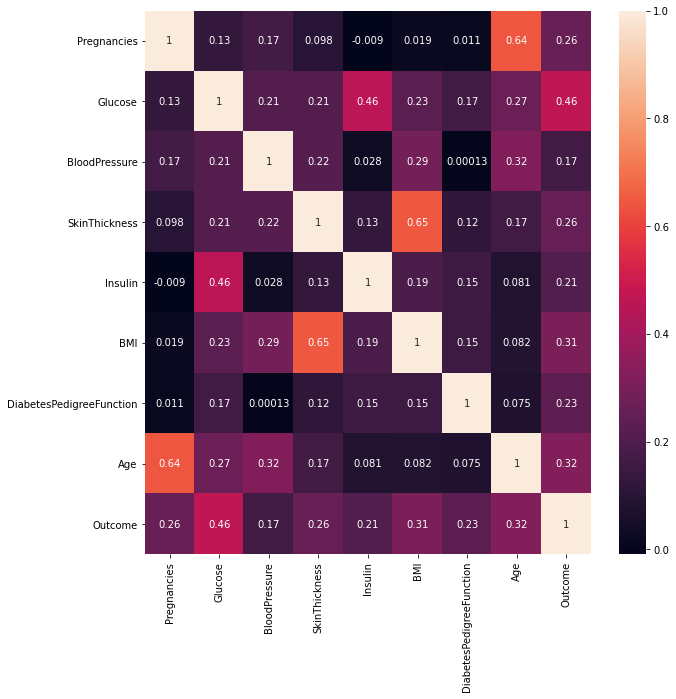

In [6]:

fig, ax = plt.subplots(figsize = (10,10))
thickzero_corrs = thickzero.corr()
#Creates a visual of each variables relationship with all the other variables and columns of this dataset.
sns.heatmap(thickzero_corrs, ax = ax, annot = True)

#### This heatmap displays the relationship between health statistics of current diabetics. The biggest relationship comes between Age and Pregnancies, which is to be expected. But the most important relationship shown is between Glucose and Insulin, where those are the largest factors for health of a diabetic, the management of blood sugar via insulin. And other criticial point was the relationship between Skin Thickness and BMI, as many diabetics inject insulin, managing their weight to keep their skin thickness down is vital.

In [50]:
xdf1 = thickzero.drop('Outcome', axis=1)
ydf1 = thickzero['Outcome']

results = sm.OLS(ydf1, xdf1).fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                Outcome   R-squared (uncentered):                   0.493
Model:                            OLS   Adj. R-squared (uncentered):              0.485
Method:                 Least Squares   F-statistic:                              64.53
Date:                Tue, 18 Apr 2023   Prob (F-statistic):                    1.88e-73
Time:                        15:13:22   Log-Likelihood:                         -286.19
No. Observations:                 539   AIC:                                      588.4
Df Residuals:                     531   BIC:                                      622.7
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                               coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

#### Insulin having the greatest P>t value is sensible, as diabetes is a hormonal disorder relating to the pancreas producing insulin.

In [8]:

bmi = thickzero['BMI']
dpf = thickzero["DiabetesPedigreeFunction"]


In [9]:
#Curve fit function
def prediction(x,m,b):
    #the return statement which is the actual function part
    return m*x+b

In [10]:
#Curve fitting for df1
#best_fit is my new variable I will fill with the values from the curve_fit function
#curve_fit is from scipy and takes in a function, x, and y values.
best_fit, just_ignore_this= curve_fit(prediction,dpf,bmi, p0 = [5, 30])

# Displays the best fit parameters which are m, and b respectively
print(best_fit)


[ 3.05877976 31.35884639]


In [11]:
m=best_fit[0]
#the value of the +b portion of the linear function
b=best_fit[1]
print(b)
#Creates an array showing all the values for the y axis
y=prediction(dpf,m,b)

print(y)

31.358846393760427
254    34.191276
519    33.139056
382    34.255511
434    34.839738
55     32.117424
         ...    
86     31.903309
120    33.680460
57     34.301393
445    38.761093
579    33.117645
Name: DiabetesPedigreeFunction, Length: 539, dtype: float64


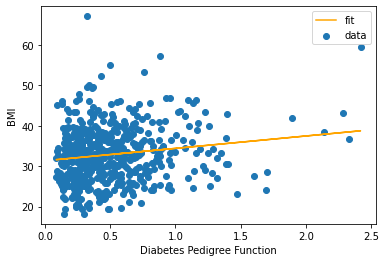

In [13]:
plt.scatter(dpf, bmi, label='data')
plt.xlabel("Diabetes Pedigree Function")
plt.ylabel("BMI")
plt.plot(dpf, y, color = 'orange', label='fit')
plt.legend()

In [51]:
selected_columns = diabetes1_df.iloc[:, [2,3,5,6]]
yloop = diabetes1_df["DiabetesPedigreeFunction"]

for i in selected_columns:
    xloop = selected_columns[i]
    results = sm.OLS(yloop, xloop).fit()
    print(results.summary())

                                    OLS Regression Results                                   
Dep. Variable:     DiabetesPedigreeFunction   R-squared (uncentered):                   0.632
Model:                                  OLS   Adj. R-squared (uncentered):              0.631
Method:                       Least Squares   F-statistic:                              1314.
Date:                      Tue, 18 Apr 2023   Prob (F-statistic):                   1.94e-168
Time:                              15:13:53   Log-Likelihood:                         -283.33
No. Observations:                       768   AIC:                                      568.7
Df Residuals:                           767   BIC:                                      573.3
Df Model:                                 1                                                  
Covariance Type:                  nonrobust                                                  
                    coef    std err          t      P>|t|   

#### The "Diabetes Pedigree Function" is a risk measurement tool to assess the risk of diabetes based on ones genetics. Where BMI is a generic health measurement based on someones height compared to their weight. While BMI is not the most accurate assessment of overall health due to factors like muscle having a higher density than fat, in these datasets, BMI generally relates to other unhealthy traits such as higher cholestorol and blood pressure, which indicates for the subjects investigated that it is not an issue of muscle mass.  Even though the Diabetes Pedigree Function relies on family history, and genetics, it does relate to BMI, where they trend upward with eachother. 



## CDC Diabetes Survaliance (Total)
### https://gis.cdc.gov/grasp/diabetes/diabetesatlas-surveillance.html

In [52]:
diabetes2_df = pd.read_csv('Datasets/DiabetesAtlas_NationalData.csv',skiprows=2,usecols=[0, 1,2,3] )


diabetes2_df.head(6)


,Year,Total - Percentage,Total - Lower Limit,Total - Upper Limit
0,2000,6.0,5.7,6.3
1,2001,6.4,6.1,6.8
2,2002,6.5,6.2,6.8
3,2003,6.6,6.3,6.9
4,2004,7.0,6.7,7.3
5,2005,7.3,7.0,7.6


In [12]:
#Removing useless spreadsheet cells
fixed= diabetes2_df.drop([0,22])
#cleaning up data so it can easily be graphed
diabetes2_df=fixed.dropna(axis='columns')

#assigning certain columns as variables using iloc to index them
year = np.array(diabetes2_df.iloc[0:,0])
#turning years to integers as it previously was reading as a string
years = np.int_(year)
total = np.array(diabetes2_df.iloc[0:,1])
low = np.array(diabetes2_df.iloc[0:,2])
high = np.array(diabetes2_df.iloc[0:,3])

#displaying the whole dataset, obtained from the cdc source 
diabetes2_df

,Year,Total - Percentage,Total - Lower Limit,Total - Upper Limit
1,2001,6.4,6.1,6.8
2,2002,6.5,6.2,6.8
3,2003,6.6,6.3,6.9
4,2004,7.0,6.7,7.3
5,2005,7.3,7.0,7.6
6,2006,7.6,7.2,8.0
7,2007,7.5,7.1,7.9
8,2008,7.9,7.5,8.4
9,2009,8.6,8.2,9.0
10,2010,8.7,8.3,9.1


In [13]:
#Curve fit function
def prediction(x,m,b):
    #the return statement which is the actual function part
    return m*x+b

In [14]:
#Curve fitting for Total-Percentage Column
#best_fit_total is my new variable I will fill with the values from the curve_fit function
#curve_fit is from scipy and takes in a function, x, and y values.
best_fit_total, just_ignore_this= curve_fit(prediction,years,total)

# Displays the best fit parameters which are m, and b respectively
print(best_fit_total)

[ 1.07142857e-01 -2.07473810e+02]


In [15]:
#the value of the m portion of the linear function for total
m_t=best_fit_total[0]
#the value of the +b portion of the linear function for total
b_t=best_fit_total[1]

#Creates an array showing all the values for the y axis on the total
ytotal= prediction(years,m_t,b_t)

print(ytotal)

[6.91904761 7.02619047 7.13333333 7.24047619 7.34761904 7.4547619
 7.56190476 7.66904761 7.77619047 7.88333333 7.99047619 8.09761904
 8.2047619  8.31190476 8.41904761 8.52619047 8.63333333 8.74047619
 8.84761904 8.9547619  9.06190476]


In [16]:
#Curve fitting for Total-Low Column
best_fit_low, just_ignore_this= curve_fit(prediction,years,low)

print(best_fit_low)

[ 1.05194805e-01 -2.03903896e+02]


In [17]:
#
m_l=best_fit_low[0]
b_l=best_fit_low[1]

ylow= prediction(years,m_l,b_l)
print(ylow)

[6.59090909 6.69610389 6.8012987  6.9064935  7.01168831 7.11688311
 7.22207792 7.32727272 7.43246753 7.53766233 7.64285714 7.74805194
 7.85324675 7.95844155 8.06363636 8.16883116 8.27402597 8.37922077
 8.48441558 8.58961039 8.69480519]


In [18]:
#Curve fitting for Total-High Column
best_fit_high, just_ignore_this = curve_fit(prediction,years,high)

print(best_fit_high)

[ 1.09610390e-01 -2.12064589e+02]


In [19]:
#
m_h=best_fit_high[0]
b_h=best_fit_high[1]

yhigh= prediction(years,m_h,b_h)

print(yhigh)

[7.26580086 7.37541125 7.48502164 7.59463203 7.70424242 7.81385281
 7.9234632  8.03307359 8.14268398 8.25229437 8.36190476 8.47151515
 8.58112554 8.69073593 8.80034632 8.90995671 9.0195671  9.12917748
 9.23878787 9.34839826 9.45800865]


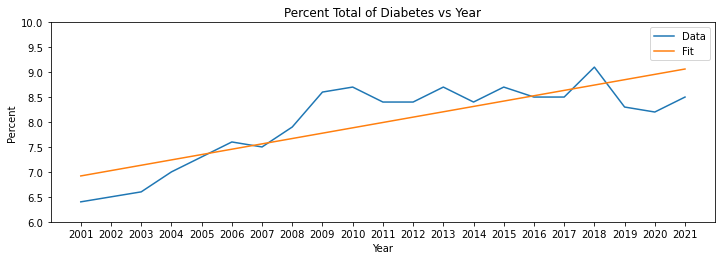

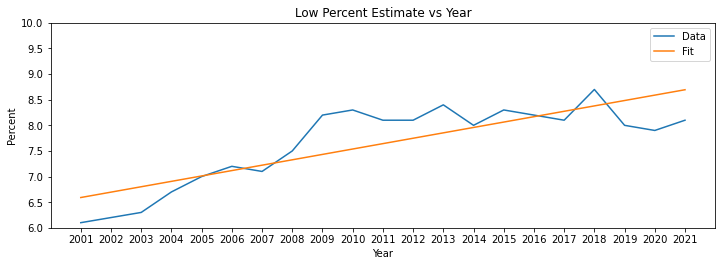

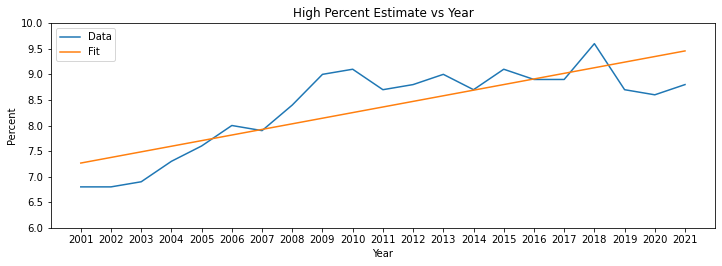

In [20]:
#Graphing the three curve fits with actual data

#Total Graph and Fit
#Setting the size of the graphs
plt.figure(figsize=(10,10))
 #Creating multiple plots
plt.subplot(3,1,1)
#Plotting data
plt.plot(years,total,label='Data')
# Plotting curve fit
plt.plot(years,ytotal,label='Fit') 
#Naming the graph to help differentiate
plt.title("Percent Total of Diabetes vs Year") 
#Labeling the x axis
plt.xlabel("Year")
#Labeling the y axis
plt.ylabel("Percent")
#Making a tick mark for each year, rather than the autogenerate x axis which has odd values like "2002.5"
plt.xticks(years)
#Displays labels given to lines
plt.legend()
#Trying to make each graph look similar enough to compare easily
plt.ylim(6,10)
#Makes the graphs much cleaner, and far less cramped
plt.tight_layout()

#High Graph and Fit
plt.figure(figsize=(10,10))
plt.subplot(3,1,2)
plt.plot(years,low,label="Data")
plt.plot(years,ylow,label='Fit')
plt.title("Low Percent Estimate vs Year")
plt.xlabel("Year")
plt.ylabel("Percent")
plt.xticks(years)
plt.ylim(6,10)
plt.legend()

plt.tight_layout()

#Low Graph and Fit
plt.figure(figsize=(10,10))
plt.subplot(3,1,3)
plt.plot(years,high,label="Data")
plt.plot(years,yhigh,label='Fit')
plt.title("High Percent Estimate vs Year")
plt.xlabel("Year")
plt.ylabel("Percent")
plt.xticks(years)
plt.legend()
plt.ylim(6,10)
plt.tight_layout()

#### The result from this curve fitting was that diabetes in the United States is still rising fairly drastically, even on the lowest end of data from the CDC. And this result gives validity to the project itself, where diabetes is an issue now, and will become a worse issue in the future as the percentage of Diabetic Americans rise.

## Kaggle Heart Disease Indicator ( with smoking)
### https://www.kaggle.com/datasets/alexteboul/heart-disease-health-indicators-dataset

In [71]:
hd_indicators_df = pd.read_csv('Datasets/heart_disease_health_indicators_BRFSS2015.csv')

hd_indicators_df["Diabetes"] = hd_indicators_df["Diabetes"].replace(2,1)

hd_indicators_df.head(10)

,HeartDiseaseorAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0
5,0.0,1.0,1.0,1.0,25.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,2.0,0.0,1.0,10.0,6.0,8.0
6,0.0,1.0,0.0,1.0,30.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,3.0,0.0,14.0,0.0,0.0,9.0,6.0,7.0
7,0.0,1.0,1.0,1.0,25.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,3.0,0.0,0.0,1.0,0.0,11.0,4.0,4.0
8,1.0,1.0,1.0,1.0,30.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,5.0,30.0,30.0,1.0,0.0,9.0,5.0,1.0
9,0.0,0.0,0.0,1.0,24.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,2.0,0.0,0.0,0.0,1.0,8.0,4.0,3.0


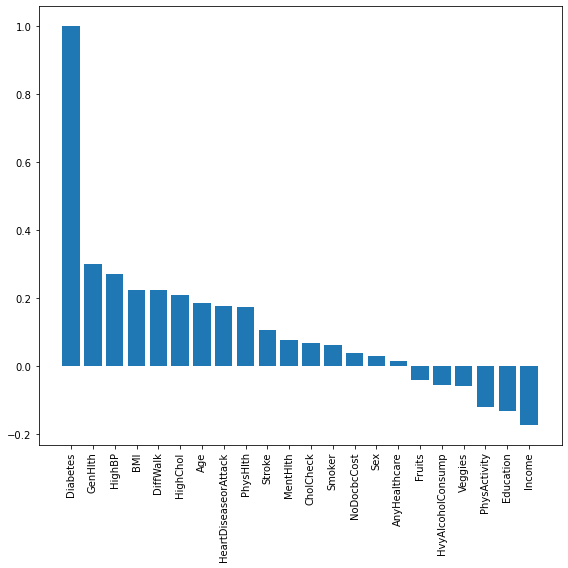

In [72]:


# corr = hd_indicators_df.corrwith(hd_indicators_df["Diabetes"])
corr = hd_indicators_df.corr()["Diabetes"].sort_values(ascending = False)

plt.figure(figsize = (8,8))
plt.bar(corr.index, corr)
plt.xticks(rotation = 90) 
plt.tight_layout()

In [73]:
hd_indicators_df2=hd_indicators_df.sort_values(by = ['Diabetes', 'GenHlth'])
#Far too many non-diabetics in this dataset, since values are 0-1, P>z to always end up at zero
hd_indicators_df2

#Turning the dataset is be closer to a 50/50 split
hd_indicators_df3=hd_indicators_df2.drop(hd_indicators_df2.head(150000).index)



In [74]:
#General Health was measured 1-5, with 5 being the best health, and 1 being the worst. The Average value is 2.5
#right in the middle
hd_indicators_df['GenHlth'].sum()/len(hd_indicators_df['GenHlth'])


2.5113923052664773

In [75]:
#Seperating the values we wish to compare Diabetes with
xdf = hd_indicators_df3.drop(columns = ["Diabetes", "MentHlth", "BMI", "PhysHlth", "Age", "Education", "Income", 
                                     "GenHlth"])
#Separating Diabetes as it's own value
ydf3 = hd_indicators_df3['Diabetes']


#Adding constant to x values
xdf3= sm.add_constant(xdf)
#Function for logistic regression to see how well the values relate
results = sm.Logit(ydf3, xdf3).fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.623269
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               Diabetes   No. Observations:               103680
Model:                          Logit   Df Residuals:                   103665
Method:                           MLE   Df Model:                           14
Date:                Tue, 18 Apr 2023   Pseudo R-squ.:                 0.06519
Time:                        15:24:11   Log-Likelihood:                -64621.
converged:                       True   LL-Null:                       -69127.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -2.7377      0.071    -38.577      0.000      -2.877      -2.599

In [76]:
HighBP = np.array(hd_indicators_df3["HighBP"])

# HighBP = HighBP.reshape(-1,1)

Diabetes = np.array(hd_indicators_df3["Diabetes"])

Smoker=np.array(hd_indicators_df3['Smoker'])

HDBMI=np.array(hd_indicators_df3['BMI'])

GENHL=np.array(hd_indicators_df3['GenHlth'])


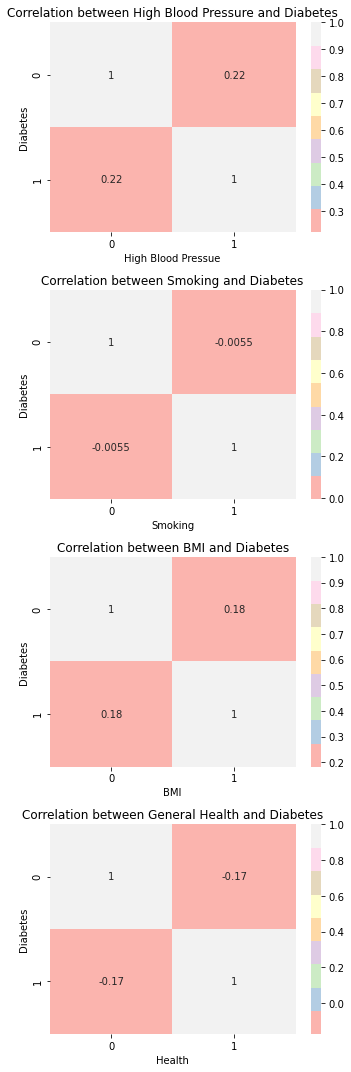

In [77]:
#Variables we're interested in (according to both the heatmap and OLS)
    #HeartDiseaseorAttack, HighBP, HighChol, BMI, GenHlth, PhysHlth, DiffWalk, Age, Education, Income

hd_indicators_df3.drop(columns = ["CholCheck","Smoker", "Stroke", "PhysActivity", "Fruits", "AnyHealthcare",
                                "NoDocbcCost", "Veggies", "HvyAlcoholConsump"])


#Creating a single vertical array out of HighBP and Diabetes
data = np.vstack([HighBP, Diabetes])
#Displaying how the values of the data relates as a numpy array
corr_matrix = np.corrcoef(data)
#Plotting numpy array as heatmap

plt.figure(figsize=(5,15))
plt.subplot(4,1,1)
sns.heatmap(corr_matrix, annot = True, cmap = "Pastel1")
plt.title("Correlation between High Blood Pressure and Diabetes")
plt.xlabel("High Blood Pressue")
plt.ylabel("Diabetes")
plt.tight_layout()

data2 = np.vstack([Smoker, Diabetes])
corr_matrix2 = np.corrcoef(data2)
plt.subplot(4,1,2)
sns.heatmap(corr_matrix2, annot = True, cmap = "Pastel1")
plt.title("Correlation between Smoking and Diabetes")
plt.xlabel("Smoking")
plt.ylabel("Diabetes")
plt.tight_layout()

data3 = np.vstack([HDBMI, Diabetes])
corr_matrix3 = np.corrcoef(data3)
plt.subplot(4,1,3)
sns.heatmap(corr_matrix3, annot = True, cmap = "Pastel1")
plt.title("Correlation between BMI and Diabetes")
plt.xlabel("BMI")
plt.ylabel("Diabetes")
plt.tight_layout()

data4 = np.vstack([GENHL, Diabetes])
corr_matrix4 = np.corrcoef(data4)
plt.subplot(4,1,4)
sns.heatmap(corr_matrix4, annot = True, cmap = "Pastel1")
plt.title("Correlation between General Health and Diabetes")
plt.xlabel("Health")
plt.ylabel("Diabetes")
plt.tight_layout()



In [78]:
hd_indicators_df = hd_indicators_df.drop(columns = ["Sex", "HvyAlcoholConsump", "Veggies", "Fruits", "Smoker",
                                                   "CholCheck", "Stroke", "PhysActivity", 
                                                   "AnyHealthcare", "NoDocbcCost", "GenHlth", "PhysHlth", "Education",
                                                   "MentHlth"])

In [82]:
xconf = hd_indicators_df.drop(columns = ["Diabetes"])
yconf = hd_indicators_df["Diabetes"]


#Separating the data to train, to run predictions
train_vectors, test_vectors, train_labels, test_labels = train_test_split(xconf, yconf, random_state = 42) 

clf = LogisticRegression(max_iter = 1000)


#Train the classifier on the data
clf.fit(train_vectors, train_labels)

y_predict = clf.predict(test_vectors)

              precision    recall  f1-score   support

         0.0       0.86      0.98      0.91     53478
         1.0       0.53      0.14      0.22      9942

    accuracy                           0.85     63420
   macro avg       0.70      0.56      0.57     63420
weighted avg       0.81      0.85      0.81     63420



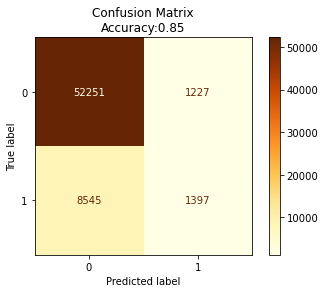

In [81]:
#Running the matrix
cm = confusion_matrix(test_labels, y_predict)


disp = ConfusionMatrixDisplay(confusion_matrix = cm)

disp.plot(cmap = "YlOrBr")
#This shows the effectiveness of the confusion matrix
accuracy = accuracy_score(test_labels, y_predict)
#These lines display the given results of the confusion matrix and accuracy scores
plt.title('Confusion Matrix\nAccuracy:{:.2f}'.format(accuracy))

print(classification_report(test_labels, y_predict))

### This dataset has shown BMI, General Health, and High Blood Pressure to relate closest to people with diabetes. This indicates those who can manage their lifestyle are often far less likely to become diabetic. BMI being a measure of height to weight can be inaccurate at times as all bodies can be shaped a bit differently, but the highest ends of the BMI chart do reflect unhealthy lifestyles, and a mixture of poor Cholestorol, High Blood Pressure and Cholestorol is a combination that will either lead to heart failure, or Type 2 diabetes. Another point this dataset makes is the relationship between those who eat a considerable amount of fruits and vegetables, and diabetes. That seems to be an issue of "cause and effect" where once someone has diabetes, for their own health they have to start eating far more fruits and vegetables. It's not that eating fruits and vegetables makes people diabetic. This also shows people who aren't diabetics are not eating as many fruits and vegetables, which definitely impacts the rate at which people gain type 2 diagnoses in the U.S.